# Trzeci milestone projektu 2. z przedmiotu WUM
### Alicja Charuza, Mateusz Gałęziewski
Poniżej przedstawiamy naszą pracę związaną z ostatecznym modelem i interpretacją klastrów.

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.cluster import OPTICS
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore')

In [3]:
class Data_Processor:

    def __init__(self):
        self.train_data = None
        self.test_data = None
        self.val_data = None

    def load_split(self, file_path):
        df = pd.read_csv(file_path)
        train_data, val_data = train_test_split(df, test_size=0.3, random_state=42)
        train_data, test_data = train_test_split(train_data, test_size=0.3, random_state=42)
        train_data.reset_index(inplace=True, drop=True)
        test_data.reset_index(inplace=True, drop=True)
        val_data.reset_index(inplace=True, drop=True)
        train_data = train_data.drop(['id'], axis=1)
        test_data = test_data.drop(['id'], axis=1)
        val_data = val_data.drop(['id'], axis=1)
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data

    def normalize_data(self):
        normalize = MinMaxScaler()
        norm_train = normalize.fit_transform(self.train_data)
        norm_test = normalize.transform(self.test_data)
        norm_val = normalize.transform(self.val_data)
        self.train_data = pd.DataFrame(norm_train, columns=self.train_data.columns)
        self.test_data = pd.DataFrame(norm_test, columns=self.test_data.columns)
        self.val_data = pd.DataFrame(norm_val, columns=self.val_data.columns)

    def get_train_data(self):
        return self.train_data
    
    def get_test_data(self):
        return self.test_data
    
    def get_val_data(self):
        return self.val_data

In [4]:
dp = Data_Processor()
dp.load_split('data/heart_disease_patients.csv')
dp.normalize_data()
X_train = dp.get_train_data()
X_test = dp.get_test_data()

### Wybrany przez nas model

Ostatecznie zdecydowaliśmy się na użycie modelu OPTICS. Wyniki osiągane przez ten model są bardzo dobre, a także dodatkowym plusem jest wykrywanie outlierów, które nie są klastrowane do żadnej klasy. Zwróciłoby to uwagę lekarzom na szczególne przypadki pacjentów, a dzięki naszemu modelowi mieliby na to czas, oszczędzając go na bardziej powszechnych przypadkach. Poniżej model OPTICS z najlepszymi przez nas znalezionymi parametrami.

In [7]:
model = OPTICS(min_samples=10, metric='l2', p=4)
pred = model.fit_predict(X_train)

Przypomnijmy, jak to wygląda na zbiorze treningowym.

In [46]:
#t-SNE
def t_sne(X, perplexity, pred):
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=perplexity).fit_transform(X)
    df1 = pd.DataFrame()
    df1['y'] = pred
    df1["comp-1"] = tsne[:,0]
    df1["comp-2"] = tsne[:,1]
    sns.scatterplot(x="comp-1", y="comp-2", hue=df1.y.tolist(),
            palette=sns.color_palette("hls", 10),
            data=df1)
#PCA
def pca_plt(X, pred, dim=2):
    pca = PCA(n_components=dim).fit_transform(X)
    df1 = pd.DataFrame()
    
    df1['y'] = pred
    for i in range(dim):
        df1[f"comp-{i}"] = pca[:,i]

    if dim == 2:
        sns.scatterplot(x="comp-0", y="comp-1", hue=df1.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df1)
    elif dim == 3:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        colors = ['red', 'orange', 'yellow', 'green', 'teal', 'skyblue', 'navy']
        cmap_custom = mcolors.ListedColormap(colors)
        ax.scatter3D(df1['comp-0'], df1['comp-1'], df1['comp-2'], c=pred, cmap=cmap_custom)
        ax.view_init(azim=45, elev=30)

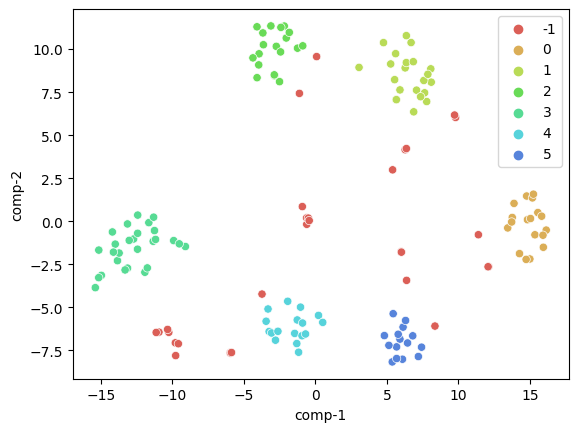

In [12]:
t_sne(X_train, 20, pred)

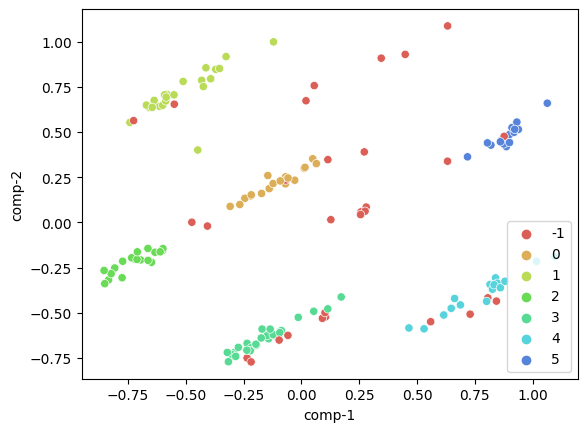

In [13]:
pca_plt(X_train, pred)

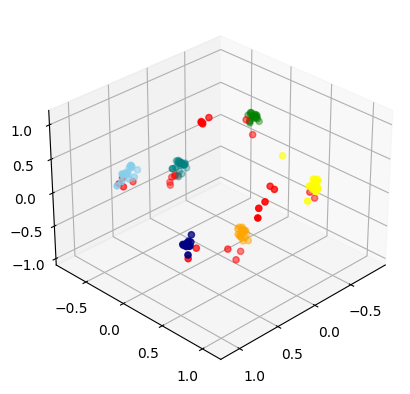

In [47]:
pca_plt(X_train, pred, 3)

Spróbujmy teraz przypisać dane testowe do utworzonych klastrów i zobaczyć, jak to wygląda. W tym celu wytrenujemy klasyfikator k-nearest neighbours na podstawie danych sklastrowanych i wykonamy predykcję na danych testowych.

In [15]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, pred)

pred_test = knn_classifier.predict(X_test)

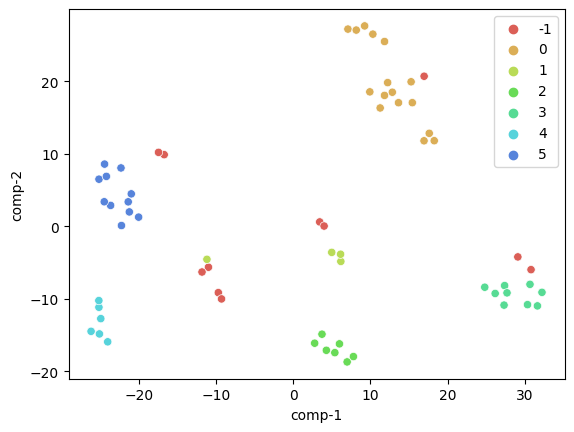

In [18]:
t_sne(X_test, 5, pred_test)

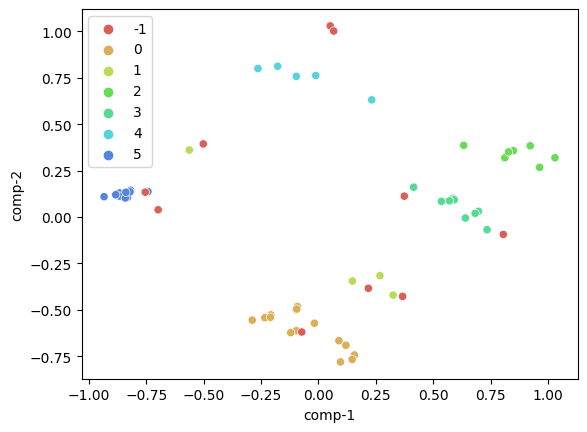

In [19]:
pca_plt(X_test, pred_test)

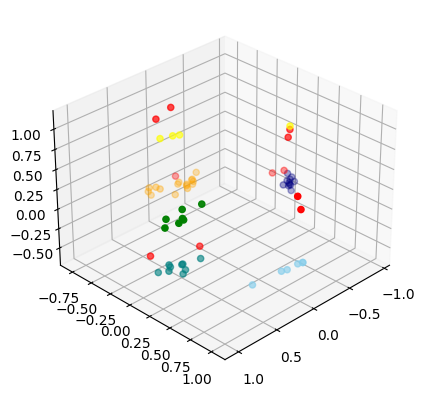

In [48]:
pca_plt(X_test, pred_test, dim=3)

Widzimy, że dane testowe również formują się w dosyć ścisłe klastry, mimo że w przypadku naszego zbioru jest ich mało.

### Interpretacja

Aby zinterpretować wyniki klastrowania posłużymy się modelem RandomForest, który wytrenujemy na danych sklastrowanych, a następnie przejrzymy cechy o wysokim feature_importance.

In [22]:
# wykonuje się około 4 minuty - nie trzeba się bać
forest = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': range(5, 11),
    'min_samples_split': range(2, 11)
}
grid_search = GridSearchCV(forest, param_grid, cv=5)
grid_search.fit(X_train, pred)
best_params = grid_search.best_params_
best_params

{'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 100}

In [59]:
feature_importances = pd.DataFrame({'Feature': X_train.columns,
                                   'Importance': grid_search.best_estimator_.feature_importances_})
feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

,Feature,Importance
0,restecg,0.200034
1,sex,0.196482
2,exang,0.134793
3,fbs,0.092216
4,thalach,0.080641
5,age,0.061187
6,trestbps,0.058054
7,chol,0.056072
8,oldpeak,0.053260
9,cp,0.042715


Widzimy, że najbardziej wpływowymi cechami na wynik są kolumny restecg, sex, exang, fbs i thalach. Przeanalizujmy teraz wartości tych kolumn w naszych klastrach.

In [76]:
def plots_clusters(cluster_num):
    sns.set(style="darkgrid")
    f, axes = plt.subplots(nrows=2, ncols=3)

    i = 0
    x, y = i//3, i%3 
    sns.histplot(x='thalach', data=X_train.loc[pred == cluster_num], ax=axes[x, y])
    axes[x,y].set_title('thalach')
    axes[x,y].set_xlabel('')
    axes[x,y].set_ylabel('')
    i += 1
        

    for column in ['sex', 'fbs', 'restecg', 'exang']:
        x, y = i//3, i%3 
        sns.countplot(x=column, data=X_train.loc[pred == cluster_num], ax=axes[x, y])
        axes[x,y].set_title(column)
        axes[x,y].set_xlabel('')
        axes[x,y].set_ylabel('')
        i += 1

    f.delaxes(axes[i//3, i%3])
    f.suptitle(f'Cluster {cluster_num}')

    plt.tight_layout()

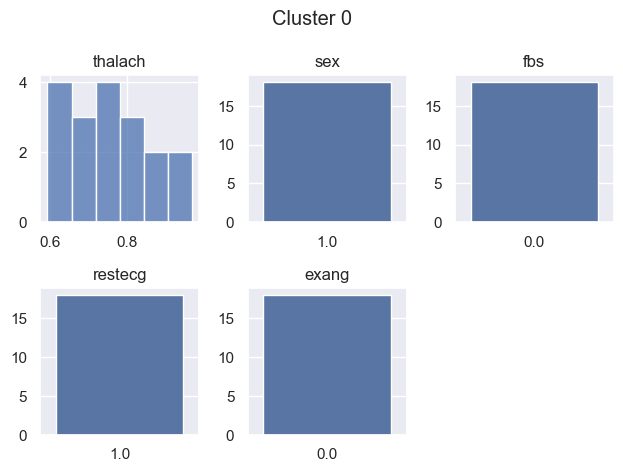

In [77]:
plots_clusters(0)

In [65]:
X_train.loc[pred == 0]['thalach'].describe()

count    18.000000
mean      0.761969
std       0.110873
min       0.593496
25%       0.672764
50%       0.756098
75%       0.825203
max       0.967480
Name: thalach, dtype: float64

Klaster zerowy zawiera samych mężczyzn, z poziomem cukru na czczo poniżej 120 mg/dl, z wynikami ekg w spoczynku w kategorii 2 (gdyż dane są znormalizowane) oraz bez obecnej dławicy wysiłkowej. Ponadto wartość thalach ma medianę około 0.76.

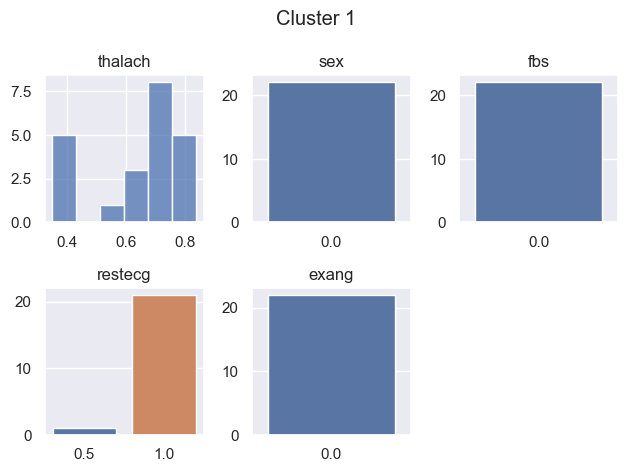

In [78]:
plots_clusters(1)

In [83]:
X_train.loc[pred == 1]['thalach'].describe()

count    22.000000
mean      0.641537
std       0.160024
min       0.349593
25%       0.589431
50%       0.699187
75%       0.729675
max       0.837398
Name: thalach, dtype: float64

Klaster pierwszy zawiera same kobiety, z poziomem cukru na czczo poniżej 120 mg/dl, z wynikami ekg w spoczynku głównie w kategorii 2, część w kategorii 1 oraz bez obecnej dławicy wysiłkowej. Ponadto wartość thalach ma medianę około 0.7.

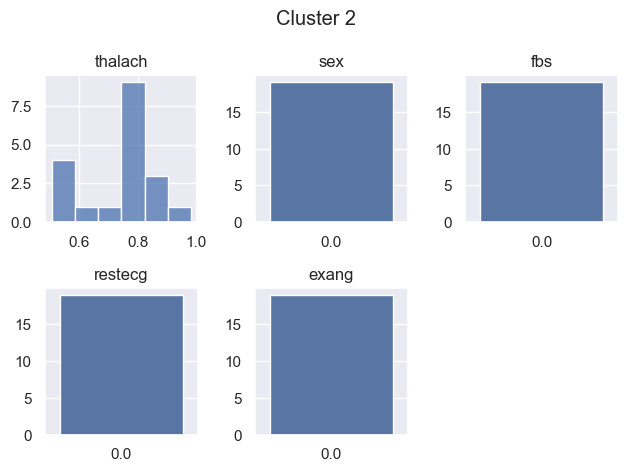

In [79]:
plots_clusters(2)

In [85]:
X_train.loc[pred == 2]['thalach'].describe()

count    19.000000
mean      0.750535
std       0.131431
min       0.504065
25%       0.691057
50%       0.764228
75%       0.821138
max       0.983740
Name: thalach, dtype: float64

Klaster drugi zawiera same kobiety, z poziomem cukru na czczo poniżej 120 mg/dl, z wynikami ekg w spoczynku w kategorii 0 oraz bez obecnej dławicy wysiłkowej. Ponadto wartość thalach ma medianę około 0.76.

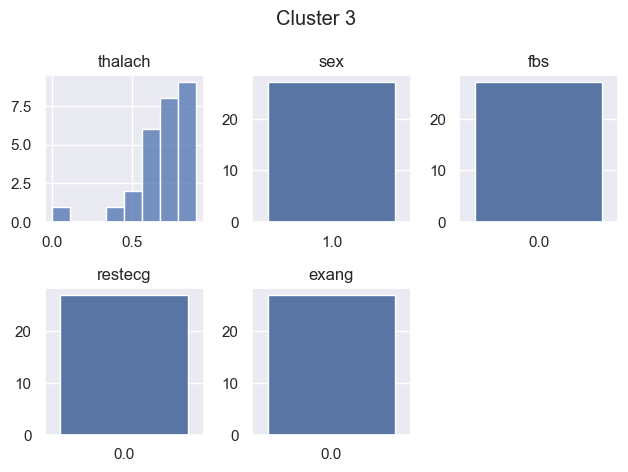

In [86]:
plots_clusters(3)

In [87]:
X_train.loc[pred == 3]['thalach'].describe()

count    27.000000
mean      0.688046
std       0.190936
min       0.000000
25%       0.638211
50%       0.739837
75%       0.808943
max       0.902439
Name: thalach, dtype: float64

Klaster trzeci zawiera samych mężczyzn, z poziomem cukru na czczo poniżej 120 mg/dl, z wynikami ekg w spoczynku w kategorii 0 oraz bez obecnej dławicy wysiłkowej. Ponadto wartość thalach ma medianę około 0.74.

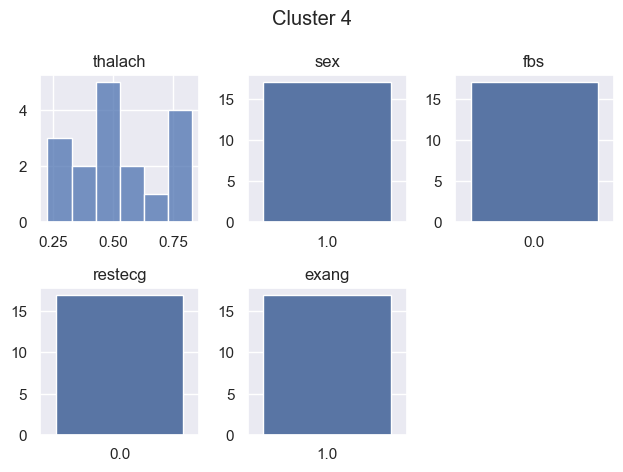

In [81]:
plots_clusters(4)

In [88]:
X_train.loc[pred == 4]['thalach'].describe()

count    17.000000
mean      0.518890
std       0.186244
min       0.227642
25%       0.398374
50%       0.479675
75%       0.674797
max       0.829268
Name: thalach, dtype: float64

Klaster czwarty zawiera samych mężczyzn, z poziomem cukru na czczo poniżej 120 mg/dl, z wynikami ekg w spoczynku w kategorii 0 oraz z obecną dławicą wysiłkową. Ponadto wartość thalach ma medianę około 0.48.

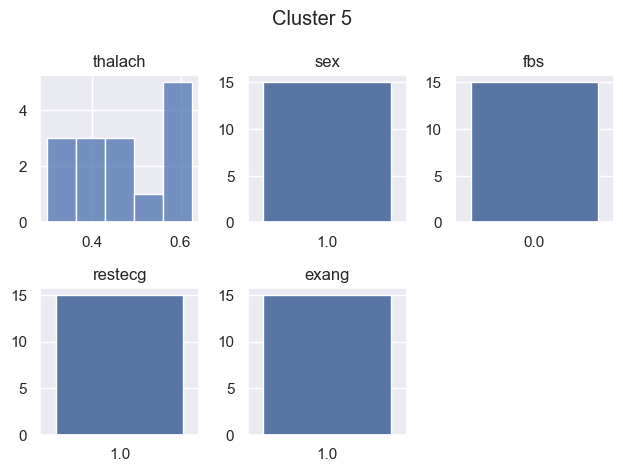

In [82]:
plots_clusters(5)

In [89]:
X_train.loc[pred == 5]['thalach'].describe()

count    15.000000
mean      0.465583
std       0.111874
min       0.300813
25%       0.373984
50%       0.471545
75%       0.569106
max       0.626016
Name: thalach, dtype: float64

Klaster piąty zawiera samych mężczyzn, z poziomem cukru na czczo poniżej 120 mg/dl, z wynikami ekg w spoczynku w kategorii 2 oraz z obecną dławicą wysiłkową. Ponadto wartość thalach ma medianę około 0.47.

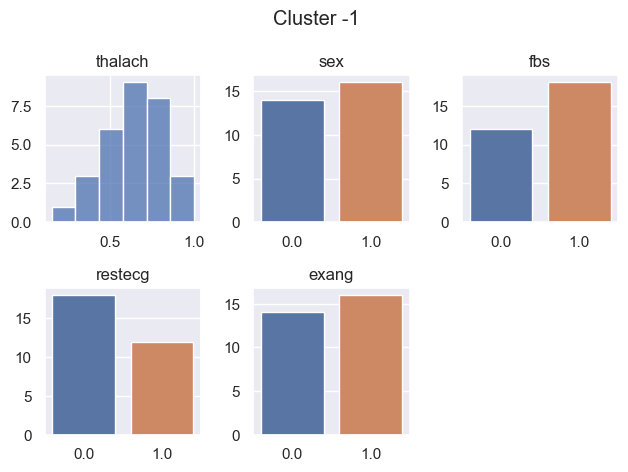

In [91]:
plots_clusters(-1)

Widzimy, że w outlierach znajdują się wszystkie osoby z podwyższonym poziomem cukru we krwi plus parę bez, a pozostałe cechy są bardzo różne. Jak dowiedzieliśmy się dzięki ChatowiGPT podwyższony poziom cukru we krwi (hiperglikemia) oraz ból serca mogą być związane, ale nie są bezpośrednio przyczyną siebie nawzajem. Istnieje kilka czynników, które mogą wpływać na równoczesną obecność tych objawów, dlatego stwierdzamy, że podjęliśmy dobrą decyzję odnośnie outlierów. Lekarze będą mogli stwierdzić, który z tych czynników zachodzi.